In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import cleaning_functions as clean

In [2]:
data = pd.read_csv('Code_challenge_train.csv')

In [3]:
data = clean.cleaning(data)

In [4]:
nulls = data.isnull().sum().to_frame()
nulls.loc[nulls[0] != 0, :]

,0


***

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop('y', axis = 1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 72019)

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

I will run through a few models quickly, using their default hyperparameters, and the full dataset, to get a rough estimate of the performance of each. Then I will invest my time in fine-tuning the model, and further feature engineering

In [8]:
def run_model(name):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 72019)
    
    if name not in [MultinomialNB, GaussianNB]:
        
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
        
        model = name()
        
        model.fit(X_train, y_train)
        
        scores = model.score(X_test, y_test)
        
        return scores
    
    else:
        mm = MinMaxScaler()
        X_train = mm.fit_transform(X_train)
        X_test = mm.transform(X_test)
        
        model = name()
        model.fit(X_train, y_train)
        
        scores = model.score(X_test, y_test)
        
        return scores

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
model_list = [MultinomialNB, GaussianNB, RandomForestClassifier, SVC, KNeighborsClassifier, SGDClassifier,
              XGBClassifier, XGBRFClassifier]
for m in model_list:
    print(m)
    print(run_model(m))
    print('--------')

<class 'sklearn.naive_bayes.MultinomialNB'>
0.797
--------
<class 'sklearn.naive_bayes.GaussianNB'>
0.2474
--------
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
0.859
--------
<class 'sklearn.svm.classes.SVC'>
0.9832
--------
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
0.9111
--------
<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
0.8471
--------
<class 'xgboost.sklearn.XGBClassifier'>
0.9041
--------
<class 'xgboost.sklearn.XGBRFClassifier'>
0.8123
--------


Looks like we have a winner. We have very imbalanced classes, I thought it would be either SVM or boosted random forests. I will still run a quick XGBoost just because I want to make sure, as SVM is slow, tuning it would take more resources

In [10]:
anova_svc = Pipeline([
    ('ss' , StandardScaler()),
    ('anova' , SelectKBest()),
    ('svc', SVC())
])

In [11]:
anova_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('anova', SelectKBest(k=10, score_func=<function f_classif at 0x1239c6730>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [12]:
anova_svc.score(X_test, y_test)

0.8599

The model did a great job when we used the whole features. 

In [13]:
pca_svc = Pipeline([
    ('ss', StandardScaler()), 
    ('pca', PCA(n_components = 5)), 
    ('svc', SVC())
])

In [14]:
pca_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [15]:
pca_svc.score(X_test, y_test)

0.797

We still need to use all the features we have to get the best accuracy possible. <br />
The SVC model is probably as good as it can get, but I will try to squeeze some more

In [9]:
ss_svc = Pipeline([
    ('ss', StandardScaler()),
    ('svm', SVC(probability = True))
])

In [17]:
# params_ss_svc = {
#     'svm__C' : [1, .5, 0.01],
#     'svm__probability' : [True],
# }

In [18]:
# gs = GridSearchCV(estimator = ss_svc, param_grid = params_ss_svc, cv = 5)

In [19]:
# # the kernel kept getting stuck at this cell, so I'll comment it out and go without fine tuning. 
# gs.fit(X_train, y_train)

In [10]:
ss_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [11]:
ss_svc.score(X_test, y_test)

0.9832

In [11]:
# we have imbalanced classes, 
ss_svc = Pipeline([
    ('ss', StandardScaler()),
    ('svc', SVC(class_weight = 'balanced', probability = True))
])

In [12]:
ss_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [13]:
ss_svc.score(X_test, y_test)

0.9865

Just quickly evaluating what I believe to be the best model we can get.

In [14]:
# get classes and probabilities predictions
preds = ss_svc.predict(X_test)
preds_probs = ss_svc.predict_proba(X_test)[:,1]

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

In [17]:
# get AUC score, and f1-score
print(f"roc_auc score: {roc_auc_score(y_test, preds).round(3)}")
print(f"f1-score: {f1_score(y_test, preds).round(3)}")

roc_auc score: 0.976
f1-score: 0.966


In [19]:
def plot_roc(preds_probs):
    
    """
    Parameters:
    -----------
    preds_probs: model.predict_proba(X_test)[:,1]
    
    """
    # ROC-curve
    fpr, tpr, _ = roc_curve(y_test, preds_probs)

    plt.figure(figsize = (6,6))
    plt.plot(fpr, tpr);
    plt.plot([0,max(y_test)],[0, max(y_test)], '--'); # it takes only encoded numerical y
    plt.title('ROC curve for the SVM classifier'.title(), fontsize = 16);
    plt.xlabel('false positive rate'.title(), fontsize = 14, color = 'purple');
    plt.ylabel('true positive rate'.title(), fontsize = 14, color = 'purple');

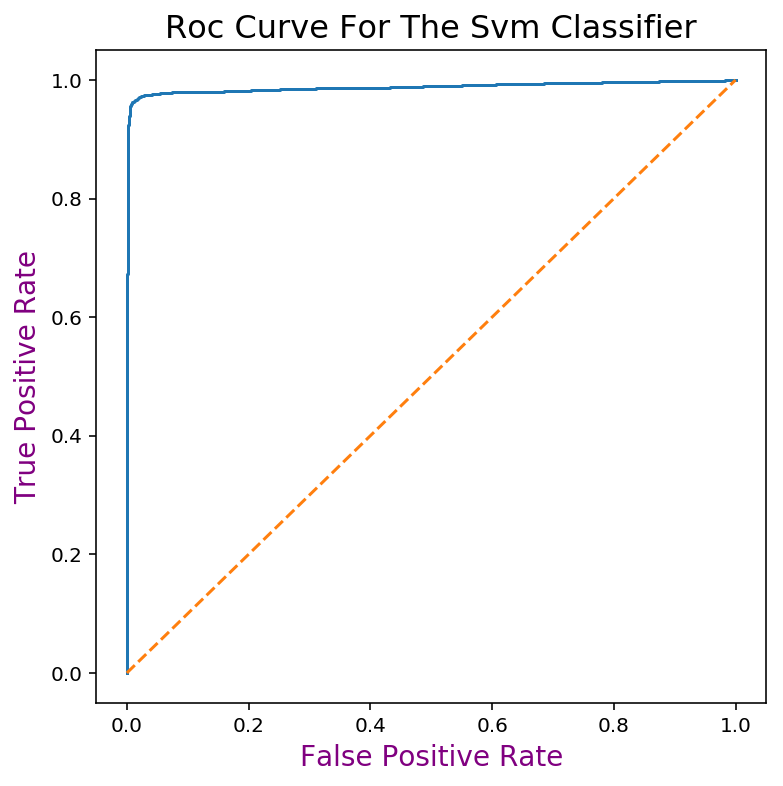

In [20]:
plot_roc(preds_probs)

***

In [24]:
# saving the model 
import pickle
filename = 'model_1_svc.sav'
pickle.dump(ss_svc, open(filename, 'wb'))